# Exam project: Scraping job postings from Jobindex

This notebook is used for webscraping www.jobindex.dk for all job postings in the period xxxx-2020. 

In [15]:
# Import necessary modules
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

import scraping_class
logfile = 'log_jobindex_scraping.txt'
connector = scraping_class.Connector(logfile)

### Define the maximum page number to do a FOR loop through
Each page of www.jobindex.dk/jobsoegning contains 20 joblistings. Since the number of job postings differ from time to time, so does the number of pages. To be able to scrape job postings on all pages, we look at the pagination. The pagination looks as the picture below, and we want to save the number of the last page as "last_page" to be able to loop through it later on.  
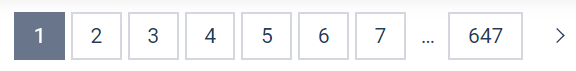

In [16]:
#Define the url and fetch the HTML using the requests module
url = 'https://www.jobindex.dk/jobsoegning?lang=da.html'
response = requests.get(url)  
html = response.text  
soup = BeautifulSoup(html,'lxml') # parse the raw html using BeautifoulSoup

#Find the pagination and page links
pagination = soup\
            .find('ul',{'class':'pagination'})\
            .find_all('a', {'class':'page-link'})
#print(pagination)

#Extract the text-part of the pagination links, i.e. not the link but the page number. 
page_list = []
for page in pagination:
    page_list.append(page.text)
    last_page = int(page_list[-1]) #Save the last page number as "last page"
print(last_page)

644


### Extract all job postings from www.jobindex.dk. 
For each job posting one is redirected from www.jobindex.dk/jobsoegning to a separate www-webpage or PDF, that contains the full job posting. We therefore have to distinguish between these two.

In [14]:
#check exercise 6.1.4??
import re
#Get all link pages from jobindex
jobindex_links = []
for i in range(1,3): # NOTE I'm only testing it on the first two pages. Use last_page+1 bc. of range when ready
    url = f'https://www.jobindex.dk/jobsoegning?lang=da?page={i}.html'
    jobindex_links.append(url)   
#print(jobindex_links)
html = []
job_links = []
for url in jobindex_links:
    response = requests.get(url)  
    html = response.text  
    soup = BeautifulSoup(html,'lxml')
    #one job result is given by class=jobsearch-result
    joblistings = soup.find_all('div',{'class':'jobsearch-result'})
    #print(joblistings)
    for joblisting in joblistings:
        links = re.findall("href=[\"\'](.*?)[\"\']", str(joblisting))
        link = links[1]
        job_links.append(link)


In [153]:
import PyPDF2 
import textract
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

jobindex_links = []
for i in range(1,3): # NOTE I'm only testing it on the first two pages. Use last_page when ready
    url = f'https://www.jobindex.dk/jobsoegning?lang=da?page={i}.html'
    jobindex_links.append(url)   
#print(jobindex_links)
html = []
job_links = []
jobs = []
for url in jobindex_links:
    response = requests.get(url)  
    html = response.text  
    soup = BeautifulSoup(html,'lxml')
    #one job result is given by class=jobsearch-result
    joblistings = soup.find_all('div',{'class':'jobsearch-result'})
    #print(joblistings)
    for joblisting in joblistings:
        title = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[0]
        links = re.findall("href=[\"\'](.*?)[\"\']", str(joblisting))
        link = str(links[1])
        link = link.replace("&amp;", "&")
        job = [title,link]
        jobs.append(job) # Jobs is a list of list where each list contains the title job, and the link for that job, this will help later
        job_links.append(link)
for i in range(len(job_links)):
    if 'pdf' in jobs[i][1][-4:]:
        #scraping a PDF file
        #request the url
        url = jobs[i][1]
        response = requests.get(url)
        #save the pdf in the current folder
        with open('pdf.pdf', 'wb') as f:
            f.write(response.content)
        #open the pdf and get the text in doc
        with open('pdf.pdf', 'rb') as fp:
            doc = slate.PDF(fp)
            doc = doc.replace('\n','')
            doc = doc.replace('\r','')
            doc = re.sub(r'\{([^)]}*\)', '', doc)
            jobs[i].append(doc)
    else:
        link = jobs[i][1]
        response = requests.get(link)
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        description = soup.get_text()
        description = description.replace('\n','')
        description = description.replace('\r','')
        description = re.sub(r'\([^)]*\)', '', description)
        jobs[i].append(description)
        


In [154]:
#transforming into dataframe

import pandas as pd
df = pd.DataFrame(jobs)
df.columns = ["Job Title", "Link", "Description"]



In [155]:
# This cell is dedicated to all cleaning the Description column

def clean(doc):
    #doc = doc.replace('\n','')
    #doc = doc.replace('\r','')
    doc = doc.replace('\t','')
    doc = doc.replace('\'','')
    doc = doc.replace('|','')
    doc = doc.replace('/','')

def strip_html(row):
    return str(html.fromstring(row).text_content())

from lxml import html
for row in df['Description']:
    strip_html(str(row))

In [224]:
# Now I would like a job type column from the job titles where I would extract the nouns from job titles
#pip install afinn
import nltk
df['Job Title']=df['Job Title'].str.replace(',','')
job_titles = list(df['Job Title'])
title = str(job_titles[0])
tokenized = nltk.word_tokenize(title)

# pp install --upgrade gensim
# pip install db
# pip install db.py
import dasem
#import db
import dasem.wiktionary
#import dasem.dannet
from dasem.wiktionary import get_nouns
#from dasem.dannet import Dannet
wiktionary_nouns = get_nouns()

nouns = []
token = tokenized[0]
if token in wiktionary_nouns:
    nouns.append(token)
    


In [220]:
wiktionary_nouns

{'sælbestand',
 'hunkat',
 'kogebog',
 'frugttræ',
 'pizzadej',
 'ruthenium',
 'kender',
 'firben',
 'bølle',
 'vante',
 'kinomaskine',
 'abc',
 'cognacglas',
 'bouillonterning',
 'dissident',
 'goliathejre',
 'vat',
 'amour',
 'satanisme',
 'glansbillede',
 'dobbeltklik',
 'bonsai',
 'korkeg',
 'chips',
 'underbegreb',
 'hug',
 'menneskesyn',
 'tunfisk',
 'rode',
 'skrin',
 'opførsel',
 'urrem',
 'blodprøve',
 'abkhaser',
 'dom',
 'jernbanespor',
 'aprilsnar',
 'bordtennisspiller',
 'kultur',
 'skistav',
 'fæces',
 'bogsamler',
 'form',
 'fortov',
 'hittegods',
 'koben',
 'fase',
 'gestus',
 'pseudodemokrati',
 'typografi',
 'database',
 'wc-rulle',
 'autokrati',
 'norden',
 'vandstof',
 'amme',
 'drypstenshule',
 'zebrafinke',
 'løvebestand',
 'Finland',
 'ishockeyspiller',
 'indånding',
 'parasol',
 'retardation',
 'vals',
 'pandeisme',
 'legende',
 'ærlighed',
 'nattefrost',
 'atomkræfternes',
 'affaldsstof',
 'kommen',
 'geodæt',
 'hovedet',
 'salpeter',
 'mp3-afspiller',
 'kasket